**Team Members:**

Ananya Krithika Thyagarajan (23187123)

Karthik Krishnamoorthy (23037687)





**THIS CODE EXECUTES TO THE END WITHOUT ANY ERROR**


In [ ]:
import numpy as np
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import deque
import os
os.environ['SDL_VIDEODRIVER'] = 'dummy'  # Handles rendering issues





In [ ]:
# Environment setup

acro_env =gym.make('Acrobot-v1', render_mode='rgb_array', new_step_api=True)
input_shape = acro_env.observation_space.shape[0]
n_outputs = acro_env.action_space.n


In [ ]:
epochs = 500
batch_size = 50
dis_rate = 0.95 #discount rate
learn_rate = 0.01
optimizer = tf.keras.optimizers.Adam('learning_rate'== learn_rate)
epsilon = 1.0
epsilon__decay = 0.995
min_epsilon = 0.01

In [ ]:
# Network and Hyperparameters

acro_model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu", input_shape=[input_shape]),  # Adjusted layer sizes
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(n_outputs)])


In [ ]:
# Replay buffer

replay_buff = deque(maxlen=2000)


In [ ]:
# Epsilon Policy

def policy_epsilon_greedy(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_val = acro_model.predict(state[np.newaxis])
        return np.argmax(Q_val[0])



In [ ]:
# Experience Sampling

def sample_exp(batch_size):
    indices = np.random.randint(len(replay_buff), size=batch_size)
    batch = [replay_buff[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch]) for field_index in range(5)
    ]
    return states, actions, rewards, next_states, dones


In [ ]:
# Training the model
loss_hist = []

def training_model(batch_size):
    global loss_hist
    states, actions, rewards, next_states, dones = sample_exp(batch_size)
    next_Q_val = acro_model.predict(next_states)
    max_next_Q_val = np.max(next_Q_val, axis=1)
    target_Q_val = rewards + (1 - dones) * dis_rate * max_next_Q_val
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = acro_model(states)
        Q_val = tf.reduce_sum(all_Q_values * mask, axis=1)
        loss = tf.reduce_mean(tf.square(target_Q_val - Q_val))
    grads = tape.gradient(loss, acro_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, acro_model.trainable_variables))
    loss_hist.append(loss.numpy())
    #return loss_hist


In [ ]:
from matplotlib import animation
from IPython.display import HTML




all_rewards = []
epsilons = []
max_steps_per_episode = 20  # Maximum steps per episode to prevent infinite loops

for episode in range(50):
    state = acro_env.reset()
    tot_reward = 0
    for step in range(max_steps_per_episode):
        action = policy_epsilon_greedy(state, epsilon)
        next_state, reward, terminated, truncated, info = acro_env.step(action)
        done = terminated or truncated
        replay_buff.append((state, action, reward, next_state, done))
        state = next_state
        tot_reward += reward
        if done:
            break
    all_rewards.append(tot_reward)
    epsilons.append(epsilon)
    epsilon = max(min_epsilon, epsilon * epsilon__decay)  # Update epsilon

    # Run the training model function periodically
    if len(replay_buff) > batch_size:
        training_model(batch_size)

    #Adding the debug statement to monitor the progress
    print(f"Episode {episode + 1}: Total Reward = {tot_reward}, Steps = {step + 1}, Epsilon = {epsilon:.4f}")


print("Training complete!")


2/2 [==============================] - 0s 4ms/step
Episode 1: Total Reward = -20.0, Steps = 20, Epsilon = 0.0664
2/2 [==============================] - 0s 5ms/step
Episode 2: Total Reward = -20.0, Steps = 20, Epsilon = 0.0661
2/2 [==============================] - 0s 5ms/step
Episode 3: Total Reward = -20.0, Steps = 20, Epsilon = 0.0658
2/2 [==============================] - 0s 6ms/step
Episode 4: Total Reward = -20.0, Steps = 20, Epsilon = 0.0654
2/2 [==============================] - 0s 5ms/step
Episode 5: Total Reward = -20.0, Steps = 20, Epsilon = 0.0651
2/2 [==============================] - 0s 4ms/step
Episode 6: Total Reward = -20.0, Steps = 20, Epsilon = 0.0648
2/2 [==============================] - 0s 5ms/step
Episode 7: Total Reward = -20.0, Steps = 20, Epsilon = 0.0645
2/2 [==============================] - 0s 4ms/step
Episode 8: Total Reward = -20.0, Steps = 20, Epsilon = 0.0641
2/2 [==============================] - 0s 4ms/step
Episode 9: Total Reward = -20.0, Steps = 20, 

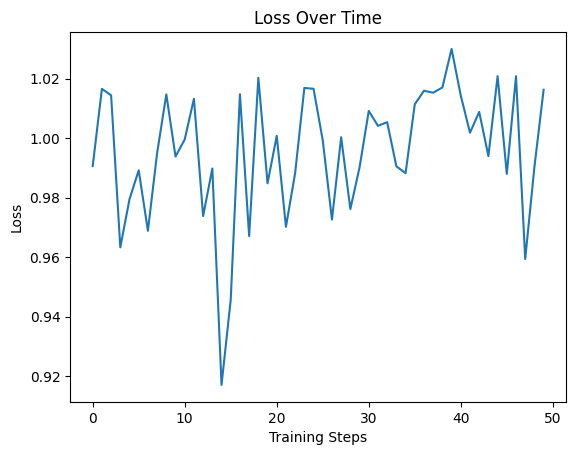

In [ ]:
import matplotlib.pyplot as plt

# plot the loss history
plt.plot(loss_hist)
plt.title('Loss Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.show()


1/1 [==============================] - 0s 22ms/step


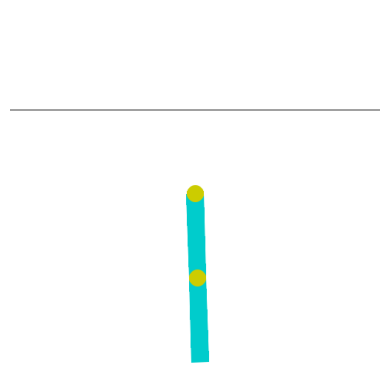

In [ ]:
frames = []
state = acro_env.reset()
for _ in range(200):
    frame = acro_env.render()  # Get the frame
    if isinstance(frame, list):  # Check if frame is a list
        frame = frame[0]  # Assume the first element in the list is the frame array
    if frame.ndim == 4 and frame.shape[0] == 1:
        frame = frame.squeeze(0)  # Remove the batch-like dimension
    frames.append(frame)

    action = policy_epsilon_greedy(state, 0)  # Epsilon=0 for using the best policy (exploitation)
    state, reward, terminated, truncated, _ = acro_env.step(action)
    if terminated or truncated:
        break

# Create the animation using matplot
fig, ax = plt.subplots()
ax.set_axis_off()
ims = [[ax.imshow(frame, animated=True)] for frame in frames]

ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000, blit=True)
# Save the animation in the current working directory
ani.save('acrobot_animation.gif', writer='pillow', fps=30)

# create a subdirectory within the current working directory
subdirectory = 'animations'
os.makedirs(subdirectory, exist_ok=True)  # Create the subdirectory if it does not exist
ani.save(f'{subdirectory}/acrobot_animation.gif', writer='pillow', fps=30)

# display the animation in the ntbk
HTML(ani.to_jshtml())


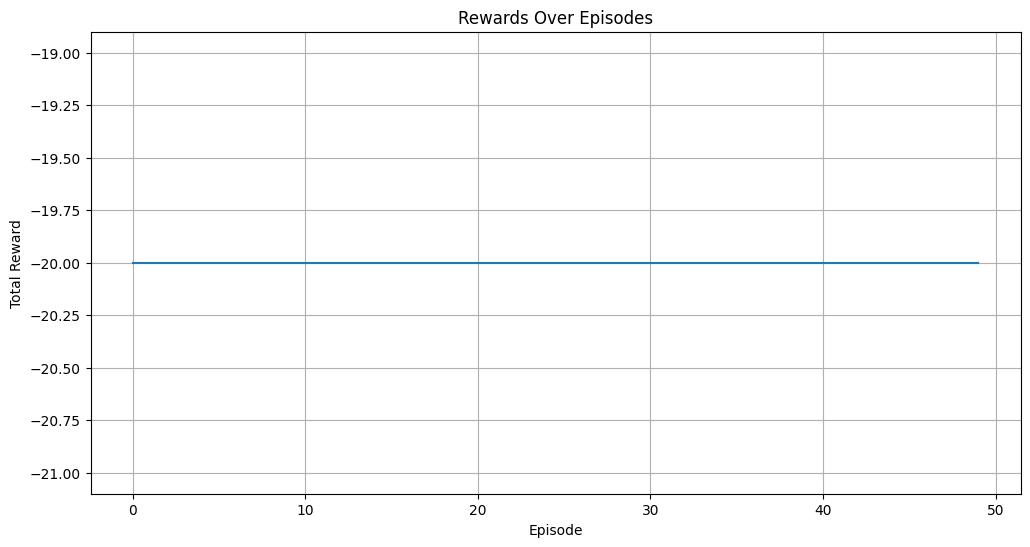

In [ ]:
# Plots rewards  over episodes
plt.figure(figsize=(12, 6))
plt.plot(all_rewards)
plt.title('Rewards Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()


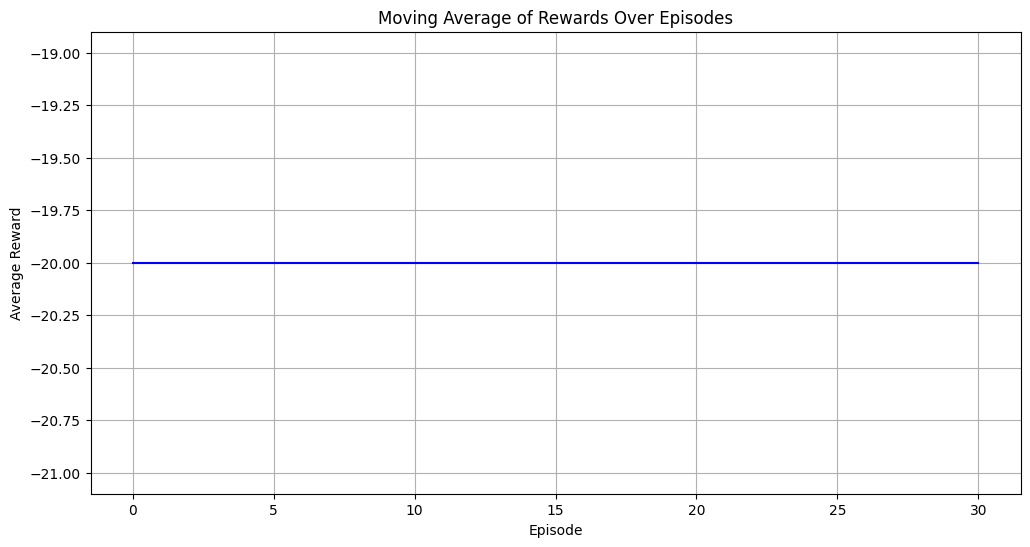

In [ ]:
# Plot Moving Average of Rewards

moving_avgrewards = np.convolve(all_rewards, np.ones(20)/20, mode='valid')  # Window size of 20 for smoothing

plt.figure(figsize=(12, 6))
plt.plot(moving_avgrewards, color='blue')
plt.title('Moving Average of Rewards Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.grid(True)
plt.show()


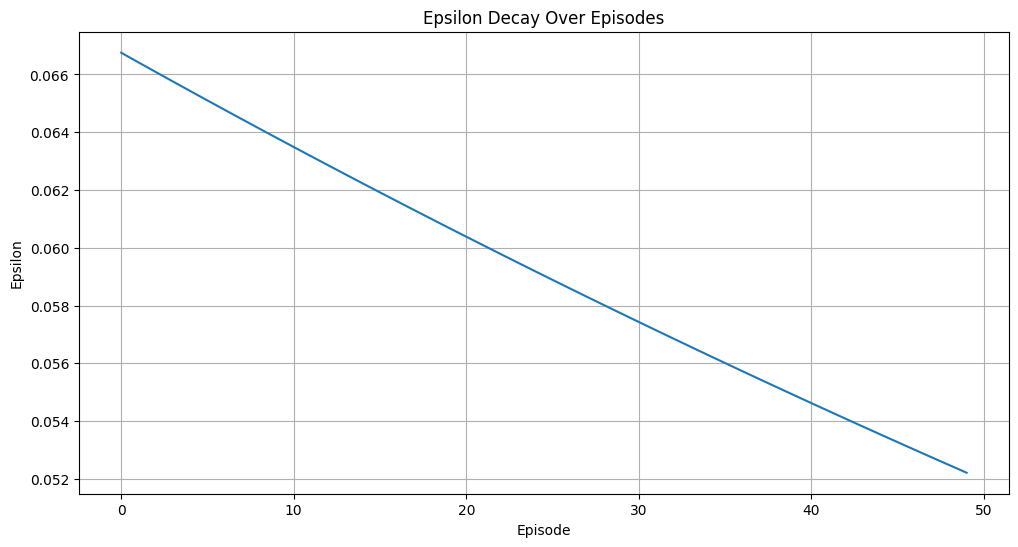

In [ ]:
# Plot Epsilon Decay

plt.figure(figsize=(12, 6))
plt.plot(epsilons)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.grid(True)
plt.show()


In [ ]:
def custom_reward_sys(next_state):

    # For Acrobot, the tip of the second link's vertical position is given by the cos of the second angle the closer this value is to 1, the higher the tip is
    cos__theta2 = next_state[1]
    return (cos__theta2 + 1) / 2  # Rescaling to be positive side

In [ ]:
#Adjusted hyperparameters
epochs = 1000
learn_rate2 = 0.001
dis_rate2 = 0.99
epsilon2 = 1.0
epsilon_decay2 = 0.96
min_epsilon2 = 0.1
batch_size2 = 64

optimizer2 = tf.keras.optimizers.Adam(learning_rate=learn_rate2)

In [ ]:
replay_buff2 = deque(maxlen=10000)  # Larger replay buffer

all_rewards2 = []
epsilons2 = []
max_steps_per_episode2 = 30  # Maximum steps per episode to prevent infinite loops

for episode in range(400):
    state = acro_env.reset()
    tot_reward2 = 0
    for step in range(max_steps_per_episode2):
        action = policy_epsilon_greedy(state, epsilon2)
        next_state, _, terminated, truncated, info = acro_env.step(action)
        custom_reward_val = custom_reward_sys(next_state)
        done = terminated or truncated
        replay_buff2.append((state, action, custom_reward_val, next_state, done))
        state = next_state
        tot_reward2 += custom_reward_val
        if done:
            break
    all_rewards2.append(tot_reward2)
    epsilons2.append(epsilon2)
    epsilon2 = max(min_epsilon2, epsilon2 * epsilon_decay2)  # Update epsilon

    # Run the training model function periodically
    if len(replay_buff2) > batch_size2:
        training_model(batch_size2)

    #Adding the debug statement to monitor the progress
    print(f"Episode {episode + 1}: Total Reward = {tot_reward2}, Steps = {step + 1}, Epsilon = {epsilon2:.4f}")


print("Training complete!")

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 4ms/step
Episode 229: Total Reward = 15.095895274818758, Steps = 30, Epsilon = 0.1000
2/2 [==============================] - 0s 5ms/step
Episode 230: Total Reward = 15.225921087461757, Steps = 30, Epsilon = 0.1000
2/2 [==============================] - 0s 4ms/step
Episode 231: Total Reward = 14.955695569049567, Steps = 30, Epsilon = 0.1000
2/2 [==============================] - 0s 6ms/step
Episode 232: Total Reward = 14.92452669236809, Steps = 30, Epsilon = 0.1000
2/2 [==============================] - 0s 5ms/step
Episode 233: Total Reward = 15.090564338956028, Steps = 30, Epsilon = 0.1000
2/2 [==============================] - 0s 5ms/step
Episode 234: Total Reward = 14.990656040274189, Steps = 30, Epsilon = 0.1000
2/2 [==============================] - 0s 4ms/step
Episode 235: Total Reward = 15.209537868417101, Steps = 30, Epsilon = 0.1000
2/2 [==============================] - 0s 4ms/step
Epi

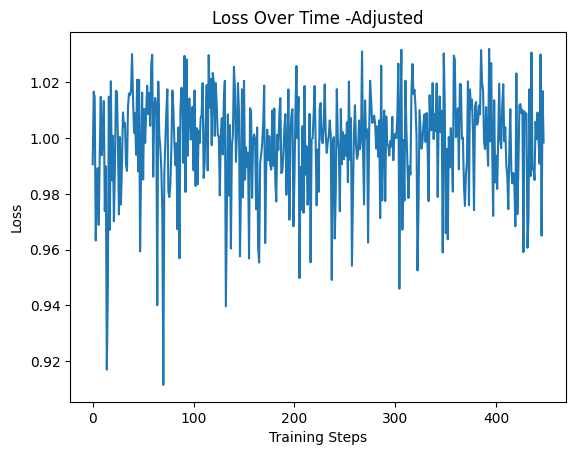

In [ ]:

# plot the loss history after adjustment
plt.plot(loss_hist)
plt.title('Loss Over Time -Adjusted')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.show()

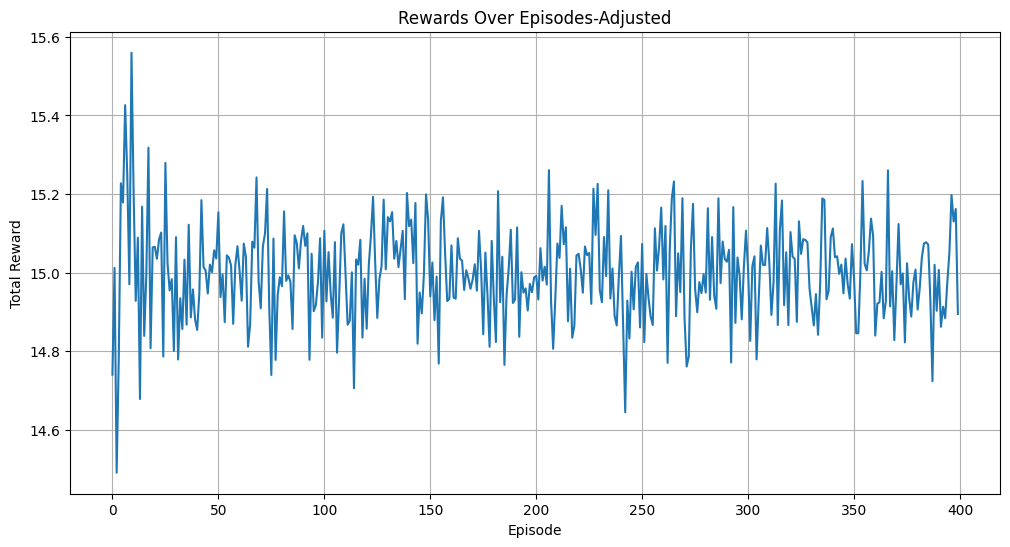

In [ ]:
# Plots rewards  over episodes
plt.figure(figsize=(12, 6))
plt.plot(all_rewards2)
plt.title('Rewards Over Episodes-Adjusted')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

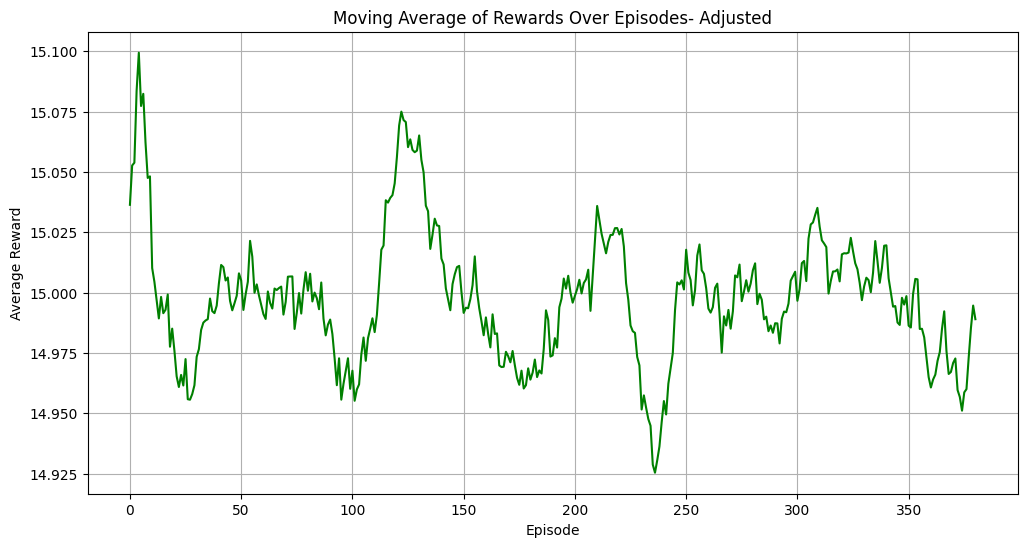

In [ ]:
# Plot Moving Average of Rewards -Adjusted

moving_avgrewards2 = np.convolve(all_rewards2, np.ones(20)/20, mode='valid')  # Window size of 20 for smoothing

plt.figure(figsize=(12, 6))
plt.plot(moving_avgrewards2, color='green')
plt.title('Moving Average of Rewards Over Episodes- Adjusted')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.grid(True)
plt.show()


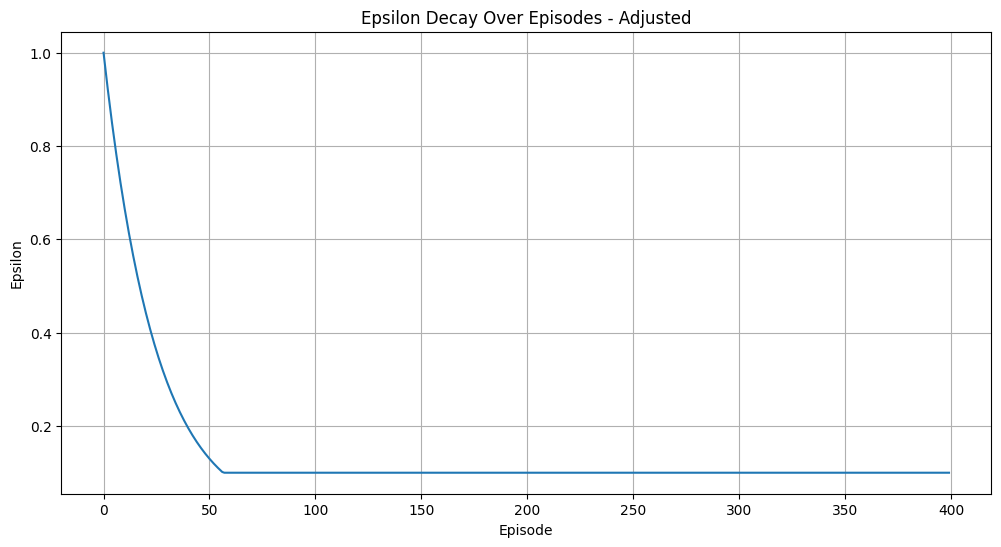

In [ ]:
# Plot Epsilon Decay -Adjusted

plt.figure(figsize=(12, 6))
plt.plot(epsilons2)
plt.title('Epsilon Decay Over Episodes - Adjusted')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 23ms/step


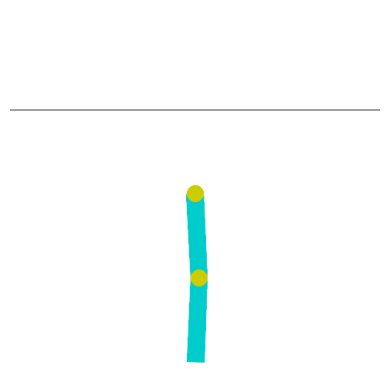

In [ ]:
subdirectory = 'animations2'
os.makedirs(subdirectory, exist_ok=True)

frames2 = []
state2 = acro_env.reset()
for _ in range(max_steps_per_episode2):
    frame2 = acro_env.render()
    if isinstance(frame2, list):
        frame2 = frame2[0] if len(frame2) == 1 else np.concatenate(frame2, axis=0)
    if frame2.ndim == 4 and frame2.shape[0] == 1:
        frame2 = frame2.squeeze(0)  # Remove the batch-like dimension
    frames2.append(frame2)

    action2 = policy_epsilon_greedy(state2, 0)  # Use the policy with epsilon=0 to exploit the best actions
    state, _, terminated, truncated, info = acro_env.step(action)
    custom_reward_val2 = custom_reward_sys(state)
    if terminated or truncated:
        break

# Create the animation using matplotlib
fig, ax = plt.subplots()
ax.set_axis_off()
ims = [[ax.imshow(frame2, animated=True)] for frame2 in frames2]

ani2 = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000, blit=True)

# Save the animation in the subdirectory
animation_path2 = f'{subdirectory}/acrobot_animation2.gif'
ani2.save(animation_path2, writer='pillow', fps=30)

# Display the animation in the notebook
HTML(ani2.to_jshtml())